<a href="https://colab.research.google.com/github/M1v1savva/cnn_emotion_recognition/blob/main/CNN_ViT_Emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Assignment: Deep Learning
By Ivan Poliakov & Dumitru Verşebeniuc

## Load the dependencies and set up the working directory

In [ ]:
!pip install scikit-plot

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.notebook import tqdm
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import scikitplot

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
# Download the FER dataset from here: https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge/data
# Align your path here
path = '/content/drive/My Drive/CV/FER/fer2013/fer2013'
os.chdir(path)

In [ ]:
os.listdir()

['README', 'fer2013.bib', 'fer2013.csv', 'final.pb', 'video.mp4', 'video1.mp4']

## Dataset parameters

## Load the dataset

In [ ]:
os.getcwd() + '/fer2013.csv'

'/content/drive/.shortcut-targets-by-id/1yUyn-ecaXfj0r_BldJY_W1UxgkGfJIBR/CV/FER/fer2013/fer2013/fer2013.csv'

In [ ]:
class DataLoader():
  def __init__(self):
    self.dataset = pd.read_csv(os.getcwd() + '/fer2013.csv')

    # Emotional mapping from numeric to text labels
    emotion_mapping = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
    self.dataset['emotion_label'] = self.dataset['emotion'].map(emotion_mapping)

    x_train, y_train, x_test, y_test, x_val, y_val = [], [], [], [], [], []
    ylabels_train = []

    progress_bar = tqdm(range(len(self.dataset)), desc="Progress", unit='metric', leave=False)
    for index, row in self.dataset.iterrows():
      dump_array = np.zeros(7)
      if row['Usage'] == 'Training':
        x_train.append(np.array(row['pixels'].split(' ')).reshape(48, 48).astype('float32') / 255)
        dump_array[row['emotion']] = 1
        y_train.append(dump_array)
      elif row['Usage'] == 'PublicTest':
        x_val.append(np.array(row['pixels'].split(' ')).reshape(48, 48).astype('float32') / 255)
        dump_array[row['emotion']] = 1
        y_val.append(dump_array)
      elif row['Usage'] == 'PrivateTest':
        x_test.append(np.array(row['pixels'].split(' ')).reshape(48, 48).astype('float32')/ 255)
        dump_array[row['emotion']] = 1
        y_test.append(dump_array)
      progress_bar.update()

    self.train = {
        "X": np.array(x_train),
        "y": np.array(y_train)
    }

    self.test = {
        "X": np.array(x_test),
        "y": np.array(y_test)
    }

    self.val = {
        "X": np.array(x_val),
        "y": np.array(y_val)
    }

  def get_info(self):
    """
    Print information about the train, validation, and test datasets.
    """
    # Information about the training dataset
    print("Training Dataset:")
    print(f"  Number of samples: {self.train['X'].shape[0]}")
    print(f"  Shape of images: {self.train['X'].shape[1:]}")
    print(f"  Number of labels: {self.train['y'].shape[0]}")

    # Information about the validation dataset
    print("\nValidation Dataset:")
    print(f"  Number of samples: {self.val['X'].shape[0]}")
    print(f"  Shape of images: {self.val['X'].shape[1:]}")
    print(f"  Number of labels: {self.val['y'].shape[0]}")

    # Information about the test dataset
    print("\nTest Dataset:")
    print(f"  Number of samples: {self.test['X'].shape[0]}")
    print(f"  Shape of images: {self.test['X'].shape[1:]}")
    print(f"  Number of labels: {self.test['y'].shape[0]}")

  def visualize_data(self):
    # Distribution of Emotion Labels
    emotion_counts = self.dataset['emotion'].value_counts().sort_index()
    emotion_counts_training = self.dataset[self.dataset['Usage'] == 'Training']['emotion'].value_counts().sort_index()
    emotion_counts_public = self.dataset[self.dataset['Usage'] == 'PublicTest']['emotion'].value_counts().sort_index()
    emotion_counts_private = self.dataset[self.dataset['Usage'] == 'PrivateTest']['emotion'].value_counts().sort_index()

    # Distribution of Emotion labels in each splits

    # Splits distribution
    usage_counts = self.dataset['Usage'].value_counts()

    # Create a figure
    fig = plt.figure(figsize=(10, 15))

    # Create a GridSpec layout
    gs = GridSpec(4, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    ax3 = fig.add_subplot(gs[1, 0:2])
    ax4 = fig.add_subplot(gs[2, 0:2])
    ax5 = fig.add_subplot(gs[3, 0:2])

    # Plotting emotion distribution
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, ax=ax1)
    ax1.set_title('Distribution of Emotion Labels')
    ax1.set_xlabel('Emotion')
    ax1.set_ylabel('Number of Samples')
    ax1.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])

    # Plotting split distribution
    sns.barplot(x=usage_counts.index, y=usage_counts.values, ax=ax2)
    ax2.set_title('Distribution of Data Usage')
    ax2.set_xlabel('Splits')
    ax2.set_ylabel('Number of Samples')

    sns.barplot(x=emotion_counts_training.index, y=emotion_counts_training.values, ax=ax3)
    ax3.set_title('Distribution of Emotion Labels in Training Split')
    ax3.set_xlabel('Emotion')
    ax3.set_ylabel('Number of Samples')
    ax3.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])

    sns.barplot(x=emotion_counts_public.index, y=emotion_counts_public.values, ax=ax4)
    ax4.set_title('Distribution of Emotion Labels in Validation Split')
    ax4.set_xlabel('Emotion')
    ax4.set_ylabel('Number of Samples')
    ax4.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])

    sns.barplot(x=emotion_counts_private.index, y=emotion_counts_private.values, ax=ax5)
    ax5.set_title('Distribution of Emotion Labels in Test Split')
    ax5.set_xlabel('Emotion')
    ax5.set_ylabel('Number of Samples')
    ax5.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])

    plt.tight_layout()
    plt.show()

In [ ]:
ds = DataLoader()

Progress:   0%|          | 0/35887 [00:00<?, ?metric/s]

In [ ]:
ds.get_info()

Training Dataset:
  Number of samples: 28709
  Shape of images: (48, 48)
  Number of labels: 28709

Validation Dataset:
  Number of samples: 3589
  Shape of images: (48, 48)
  Number of labels: 3589

Test Dataset:
  Number of samples: 3589
  Shape of images: (48, 48)
  Number of labels: 3589


<ipython-input-51-5fc4b68d0c91>:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])
<ipython-input-51-5fc4b68d0c91>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])
<ipython-input-51-5fc4b68d0c91>:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])
<ipython-input-51-5fc4b68d0c91>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])


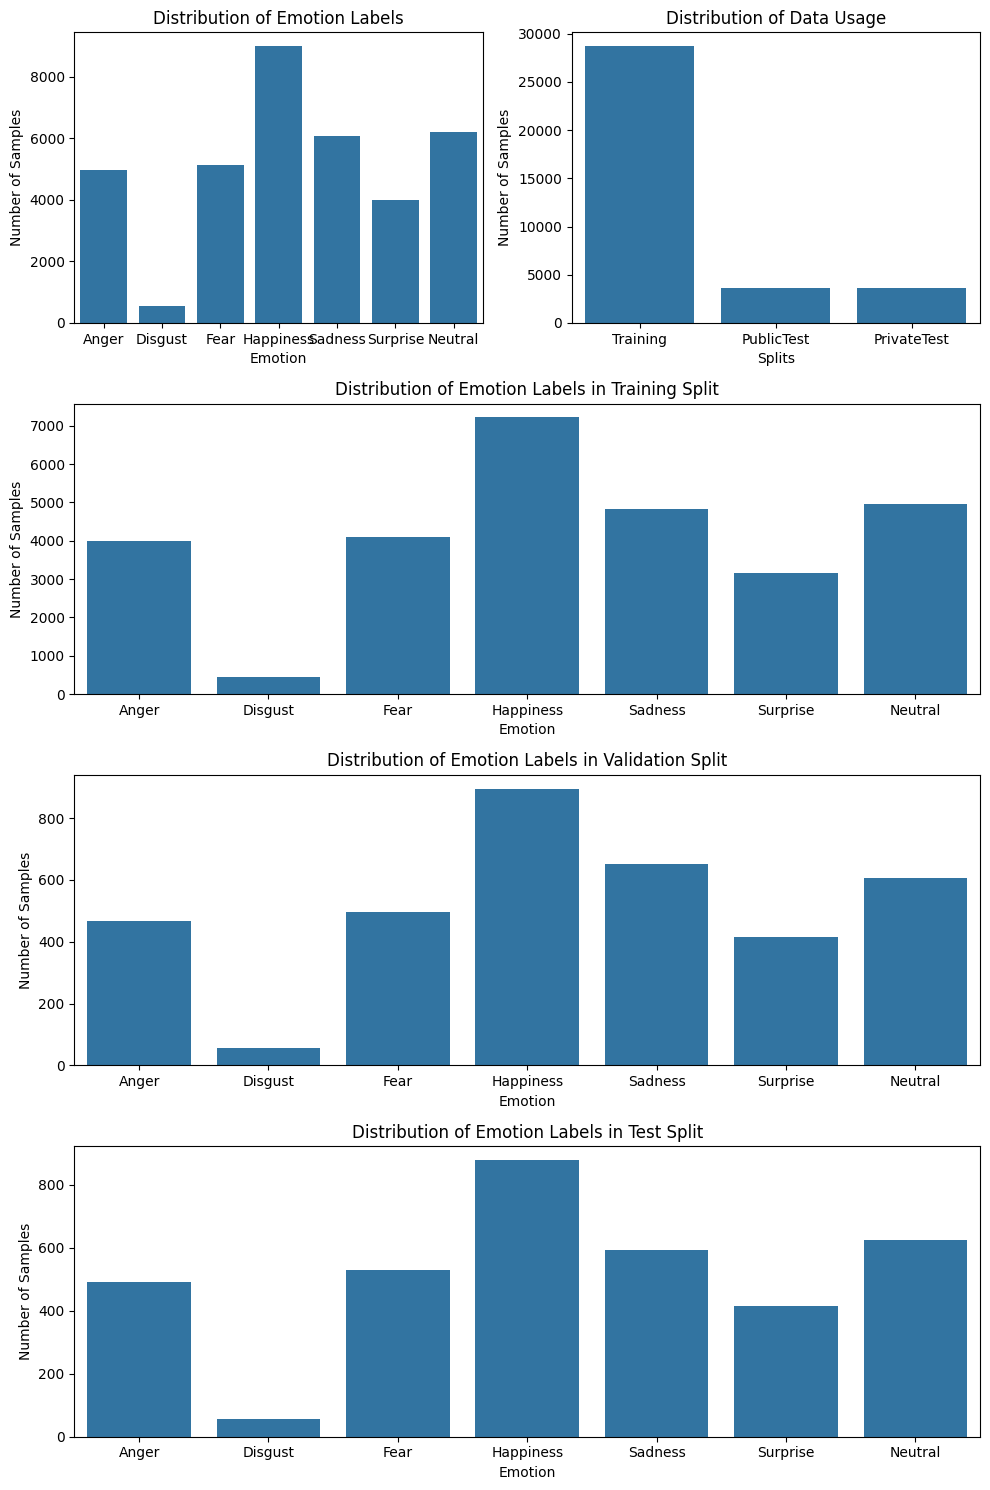

In [ ]:
ds.visualize_data()

## Model selection

In [ ]:
# @title train from scratch or load saved CNN weights for the final model

train_from_scratch = False # @param ["False", "True"] {type:"raw"}

epochs = 20 # @param {type:"integer"}

modification = 'smaller kernel' # @param mod_options = ["default", "no batch normalization", "no max pooling", 'average pooling', 'fewer layers', 'fewer channels', 'more channels', 'smaller kernel', 'bigger kernel', 'increased stride', 'SmallKernelMoreChannels']


## Prepare the model

In [ ]:
NUM_CLASSES = 7

In [ ]:
# @title main CNN architecture
class CNN():
  def __init__(self, dataset, input = (48, 48, 1), padding = 'same', strides=1, optimizer='adam', loss='categorical_crossentropy'):
    self.layers = []
    self.strides = strides
    self.padding = padding
    self.dataset = dataset
    self.optimizer = optimizers.Adam(0.001)
    self.loss = loss
    self.metrics = ['accuracy']

    # Create Input
    self.input = tf.keras.layers.Input(shape=input)
    self.x = self.input
    self.setup_network()

  def add_conv_layer(self, activation='elu', kernel=(3, 3), channels=8):
    self.x = tf.keras.layers.Conv2D(channels, kernel, activation=activation, padding=self.padding, strides=self.strides)(self.x)

  def add_batch_norm_layer(self):
    self.x = tf.keras.layers.BatchNormalization()(self.x)

  def add_deconv_layer(self, activation='elu', kernel=(3, 3), channels=8):
    self.x = tf.keras.layers.Conv2DTranspose(channels, kernel, activation=activation, padding=self.padding, strides=self.strides, kernel_initializer='he_normal')(self.x)

  def add_max_pooling_layer(self, kernel=(2, 2)):
    self.x = tf.keras.layers.MaxPooling2D(kernel, padding=self.padding)(self.x)

  def add_average_pooling_layer(self, kernel=(2, 2)):
    self.x = tf.keras.layers.AveragePooling2D(kernel, padding=self.padding)(self.x)

  def add_upsampling_layer(self, kernel=(2,2)):
    self.x = tf.keras.layers.UpSampling2D(kernel)(self.x)

  def add_dropout_layer(self, rate=0.4):
    self.x = tf.keras.layers.Dropout(rate)(self.x)

  def add_flatten_layer(self):
    self.x = tf.keras.layers.Flatten()(self.x)

  def add_dense_layer(self, units, activation='elu'):
    self.x = tf.keras.layers.Dense(units, activation=activation, kernel_initializer='he_normal')(self.x)

  def add_final_dense_layer(self, units, activation='softmax'):
    self.x = tf.keras.layers.Dense(units, activation=activation)(self.x)

  def setup_network(self):
    # CNN

    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

  def create_model(self, optimizer, loss, metrics):
    self.model = tf.keras.Model(self.input, self.x)
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, epochs=10, batch_size=32, shuffle=True):
    if (self.model is None):
      raise Exception("Model must be initialized before training!")

    self.evolution = self.model.fit(self.dataset.train['X'],
                                    self.dataset.train['y'],
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    validation_data=(self.dataset.val['X'], self.dataset.val['y']))

  def train_augmented(self, epochs=10, batch_size=32, shuffle=True):
    if (self.model is None):
      raise Exception("Model must be initialized before training!")

    y_train_labels = np.argmax(self.dataset.train['y'], axis=1)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))

    high_aug_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    high_aug_datagen.fit(self.dataset.train['X'].reshape(-1, 48, 48, 1))

    self.evolution = self.model.fit(high_aug_datagen.flow(self.dataset.train['X'].reshape(-1, 48, 48, 1), self.dataset.train['y'], batch_size=batch_size),
                                    epochs=epochs,
                                    shuffle=shuffle,
                                    validation_data=(self.dataset.val['X'], self.dataset.val['y']),
                                    class_weight=class_weight_dict)

  def evaluate(self, epochs=10, batch_size=128, shuffle=True):
    if hasattr(self, 'evolution'):
      plt.plot(self.evolution.history['loss'], label='Training Loss')
      plt.plot(self.evolution.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

    print("\nTest: ")
    base_model.model.evaluate(ds.test['X'], ds.test['y'])

    y_predicted = np.argmax(base_model.model(ds.test['X']), axis=1)
    scikitplot.metrics.plot_confusion_matrix(np.argmax(ds.test['y'], axis=1), y_predicted, figsize=(7,7))

    print(f"Size of test data: {len(ds.test['y'])}")
    print(f"Wrong predictions: {np.sum(np.argmax(ds.test['y'], axis=1) != y_predicted)}\n\n")
    print(classification_report(np.argmax(ds.test['y'], axis=1), y_predicted))

  def save_model(self, path):
        self.model.save(path + ".pb")

  def load_model(self, path):
      self.model = tf.keras.models.load_model(path + ".pb")

In [ ]:
# @title Average Pooling CNN

class AveragePoolingCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_average_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()

    self.add_average_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_average_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title No Max Pooling CNN

class NoMaxPoolingCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()

    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title No Batch Norm CNN

class NoBatchNormCNN():
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_conv_layer(channels=64, kernel=(5,5))

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_conv_layer(channels=128)

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_conv_layer(channels=256)

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title Fewer Layers CNN

class FewerLayersCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title Fewer Channels CNN

class FewerChannelsCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=32, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=32, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=64)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=64)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=64)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title More Channels CNN

class MoreChannelsCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=128, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=512)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=512)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title Smaller Kernel CNN

class SmallerKernelCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(3,3))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=64, kernel=(3,3))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title Bigger Kernel CNN

class BiggerKernelCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=64, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=128, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256, kernel=(5,5))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256, kernel=(5,5))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
# @title SmallKernelMoreChannels CNN
class SmallKernelMoreChannelsCNN(CNN):
  def setup_network(self):
    self.add_conv_layer(channels=64, kernel=(3,3))
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=128, kernel=(3,3))
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=256)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.4)

    self.add_conv_layer(channels=512)
    self.add_batch_norm_layer()
    self.add_conv_layer(channels=512)
    self.add_batch_norm_layer()

    self.add_max_pooling_layer()
    self.add_dropout_layer(rate=0.5)

    self.add_flatten_layer()
    self.add_dense_layer(units=128)

    self.add_batch_norm_layer()
    self.add_dropout_layer(rate=0.6)

    self.add_final_dense_layer(units=NUM_CLASSES)

    self.create_model(self.optimizer, self.loss, self.metrics)

In [ ]:
base_model = None

if modification == 'default':
  base_model = CNN(dataset=ds)
elif modification == "no batch normalization":
  base_model = NoBatchNormCNN(dataset=ds)
elif modification == 'no max pooling':
  base_model = NoMaxPoolingCNN(dataset=ds)
elif modification == 'average pooling':
  base_model = AveragePoolingCNN(dataset=ds)
elif modification == 'fewer layers':
  base_model = FewerLayersCNN(dataset=ds)
elif modification == 'fewer channels':
  base_model = FewerChannelsCNN(dataset=ds)
elif modification == 'more channels':
  base_model = MoreChannelsCNN(dataset=ds)
elif modification == 'smaller kernel':
  base_model = SmallerKernelCNN(dataset=ds)
elif modification == 'bigger kernel':
  base_model = BiggerKernelCNN(dataset=ds)
elif modification == 'increased stride':
  base_model = CNN(dataset=ds, stride=2)
elif modification == 'SmallKernelMoreChannels':
  base_model = SmallKernelMoreChannelsCNN(dataset=ds)

if not train_from_scratch:
  base_model.load_model("final")

In [ ]:
base_model.model

In [ ]:
base_model.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0   

In [ ]:
if train_from_scratch:
    if True:
      base_model.train(20, 32, True)
    else:
      base_model.train_augmented(20, 32, True)

## Evaluate the model


Test: 
113/113 [==============================] - 60s 532ms/step - loss: 1.0484 - accuracy: 0.6436
Size of test data: 3589
Wrong predictions: 1279


              precision    recall  f1-score   support

           0       0.58      0.59      0.58       491
           1       0.81      0.53      0.64        55
           2       0.57      0.35      0.43       528
           3       0.79      0.88      0.83       879
           4       0.50      0.52      0.51       594
           5       0.76      0.77      0.77       416
           6       0.56      0.65      0.60       626

    accuracy                           0.64      3589
   macro avg       0.65      0.61      0.62      3589
weighted avg       0.64      0.64      0.64      3589



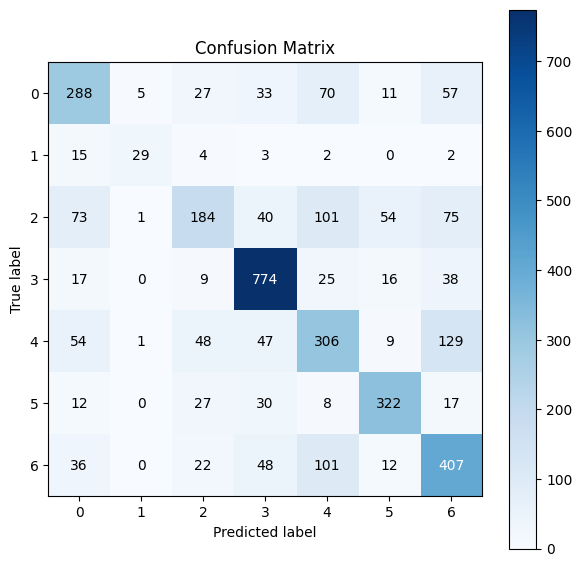

In [ ]:
base_model.evaluate()

## Visualize layers

In [ ]:
class VisualizeCNN(CNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def model_activations(self):
        layer_outputs = [layer.output for layer in self.model.layers if 'conv' in layer.name]
        activation_model = tf.keras.models.Model(inputs=self.model.input, outputs=layer_outputs)
        return activation_model


In [ ]:
v_model = VisualizeCNN(dataset=ds)
v_model.load_model("final")
activation_model = v_model.model_activations()

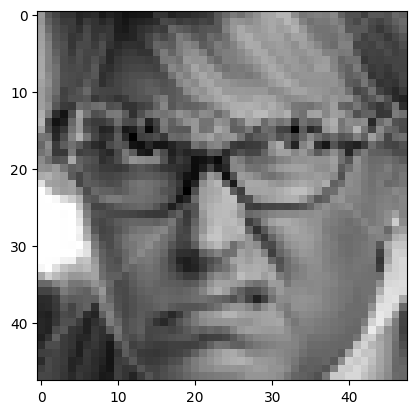

In [ ]:
plt.imshow(ds.test['X'][0], cmap='gray')

1/1 [==============================] - 0s 199ms/step


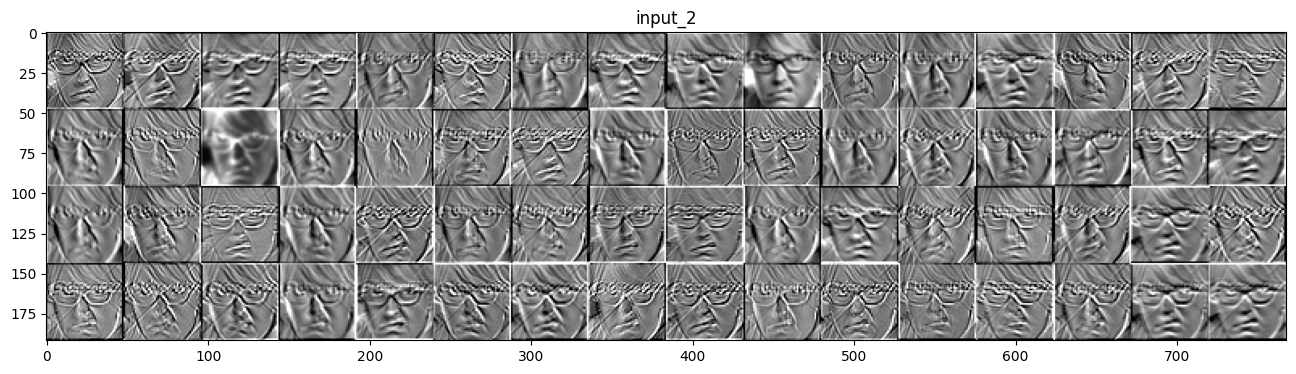

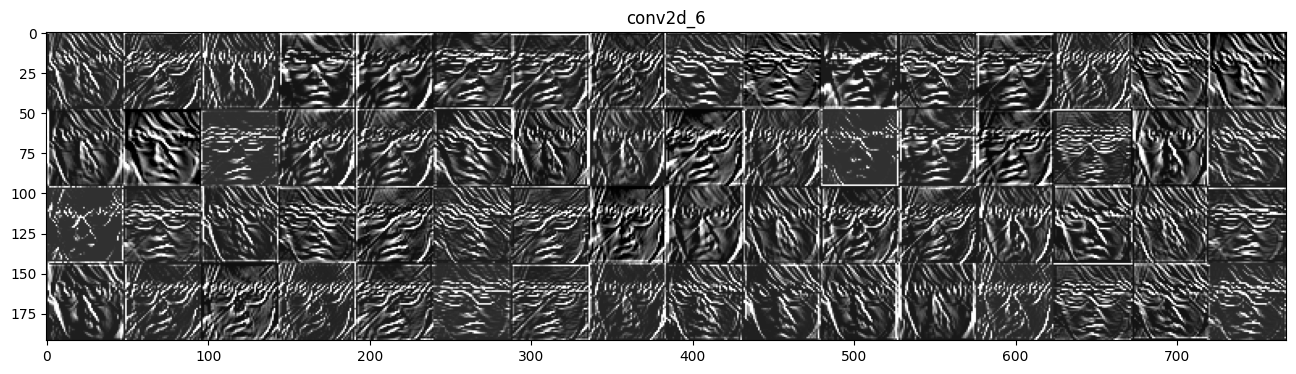

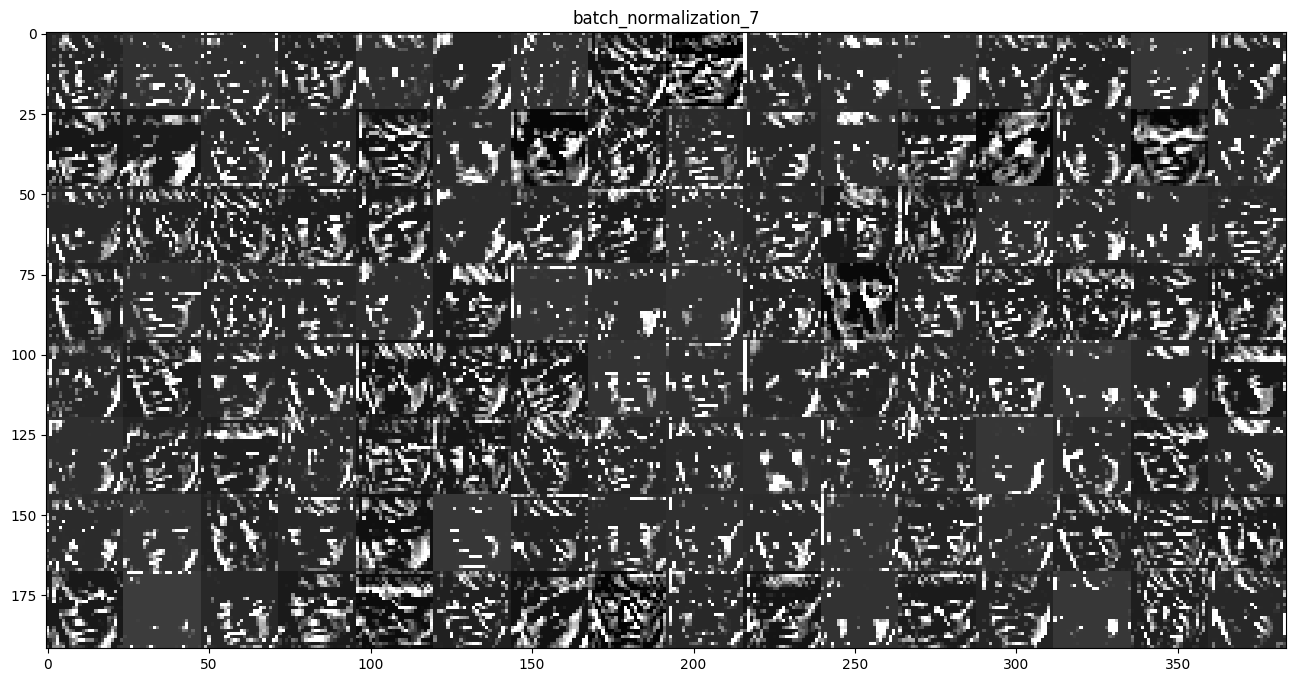

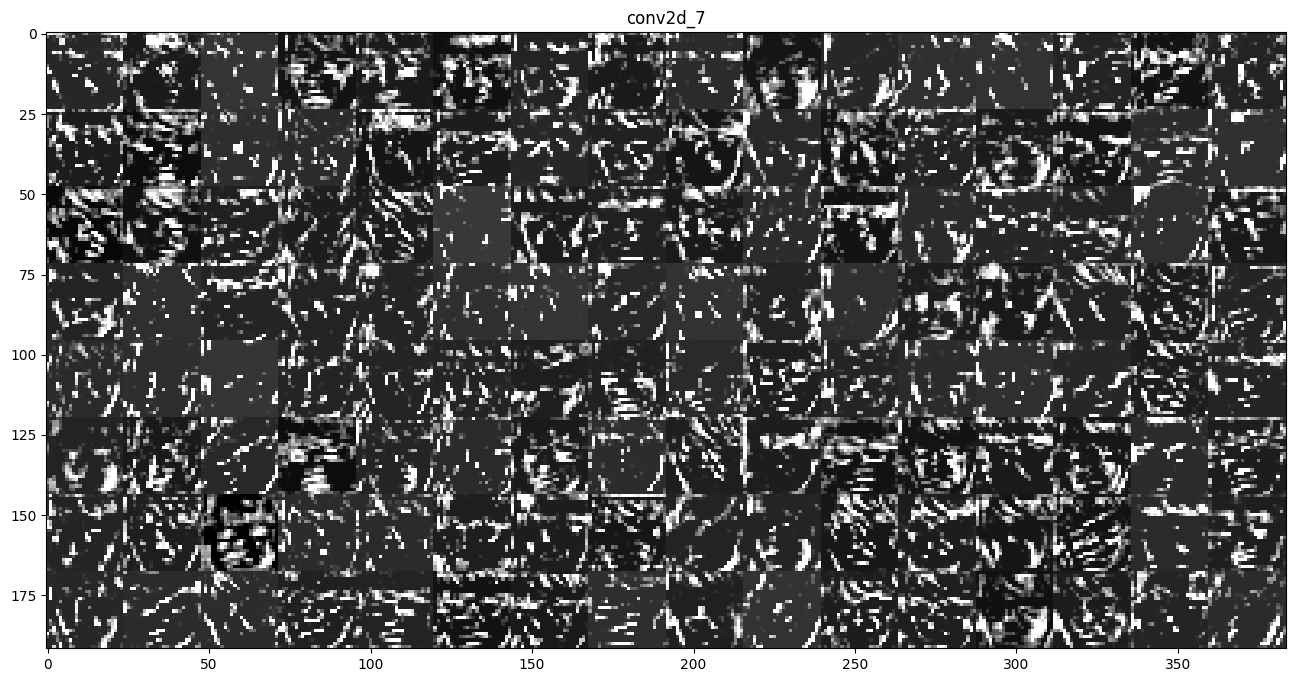

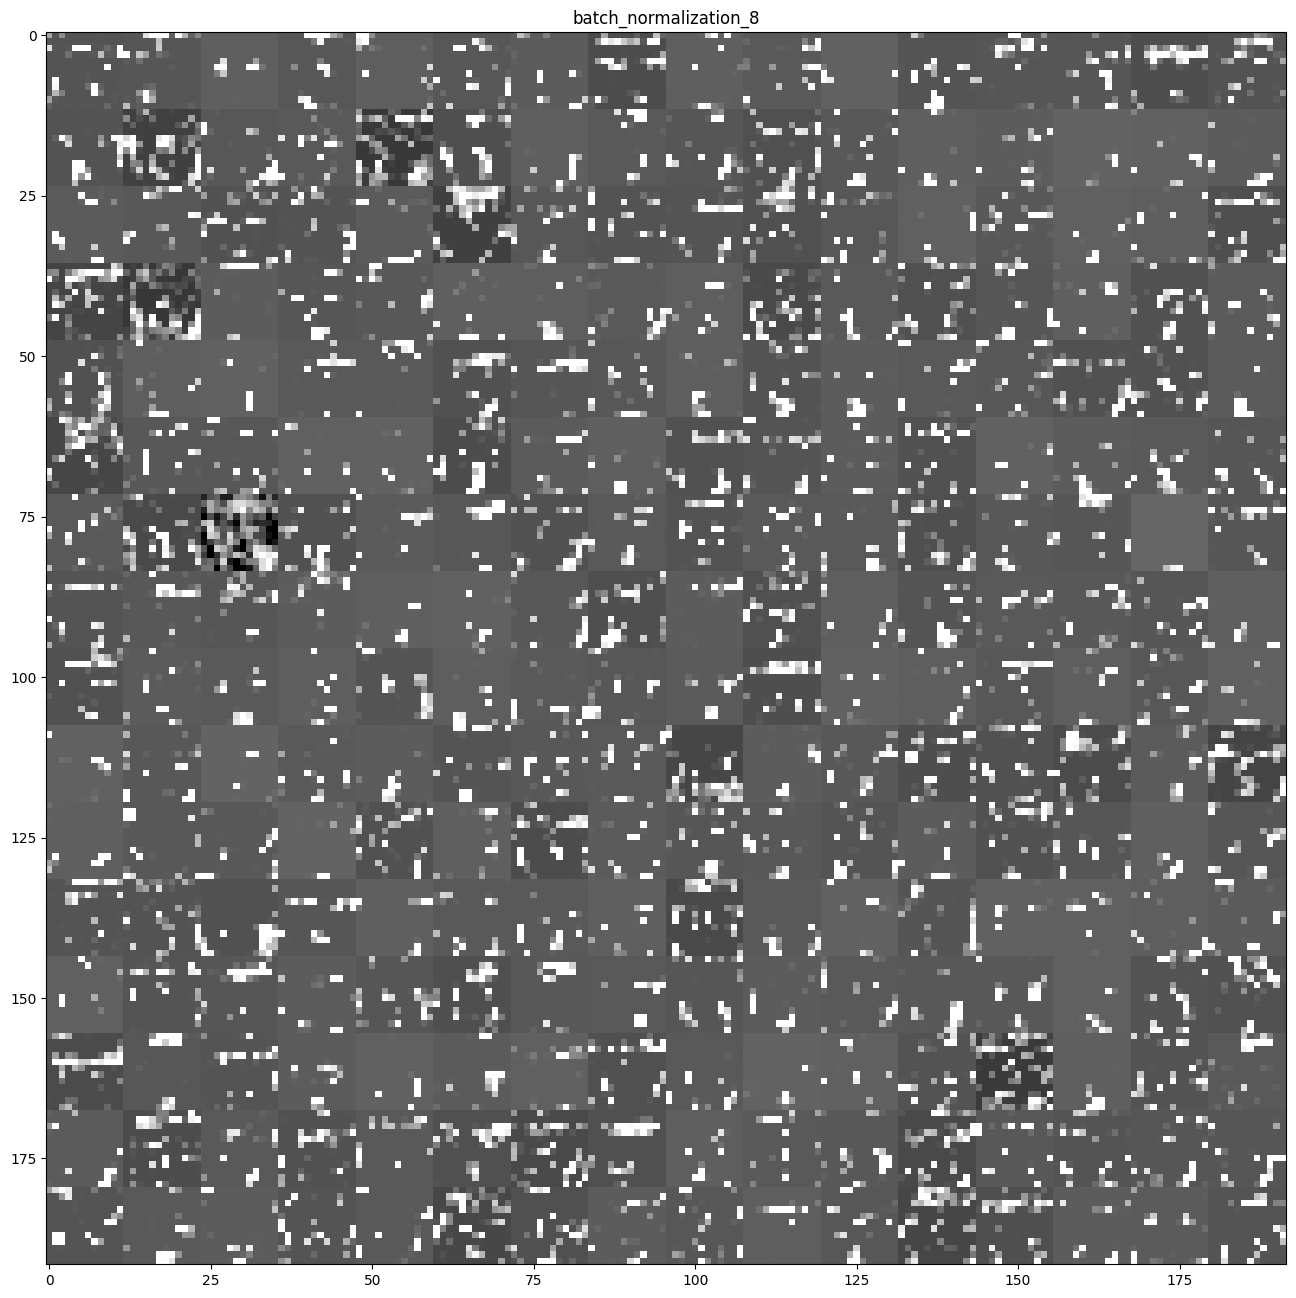

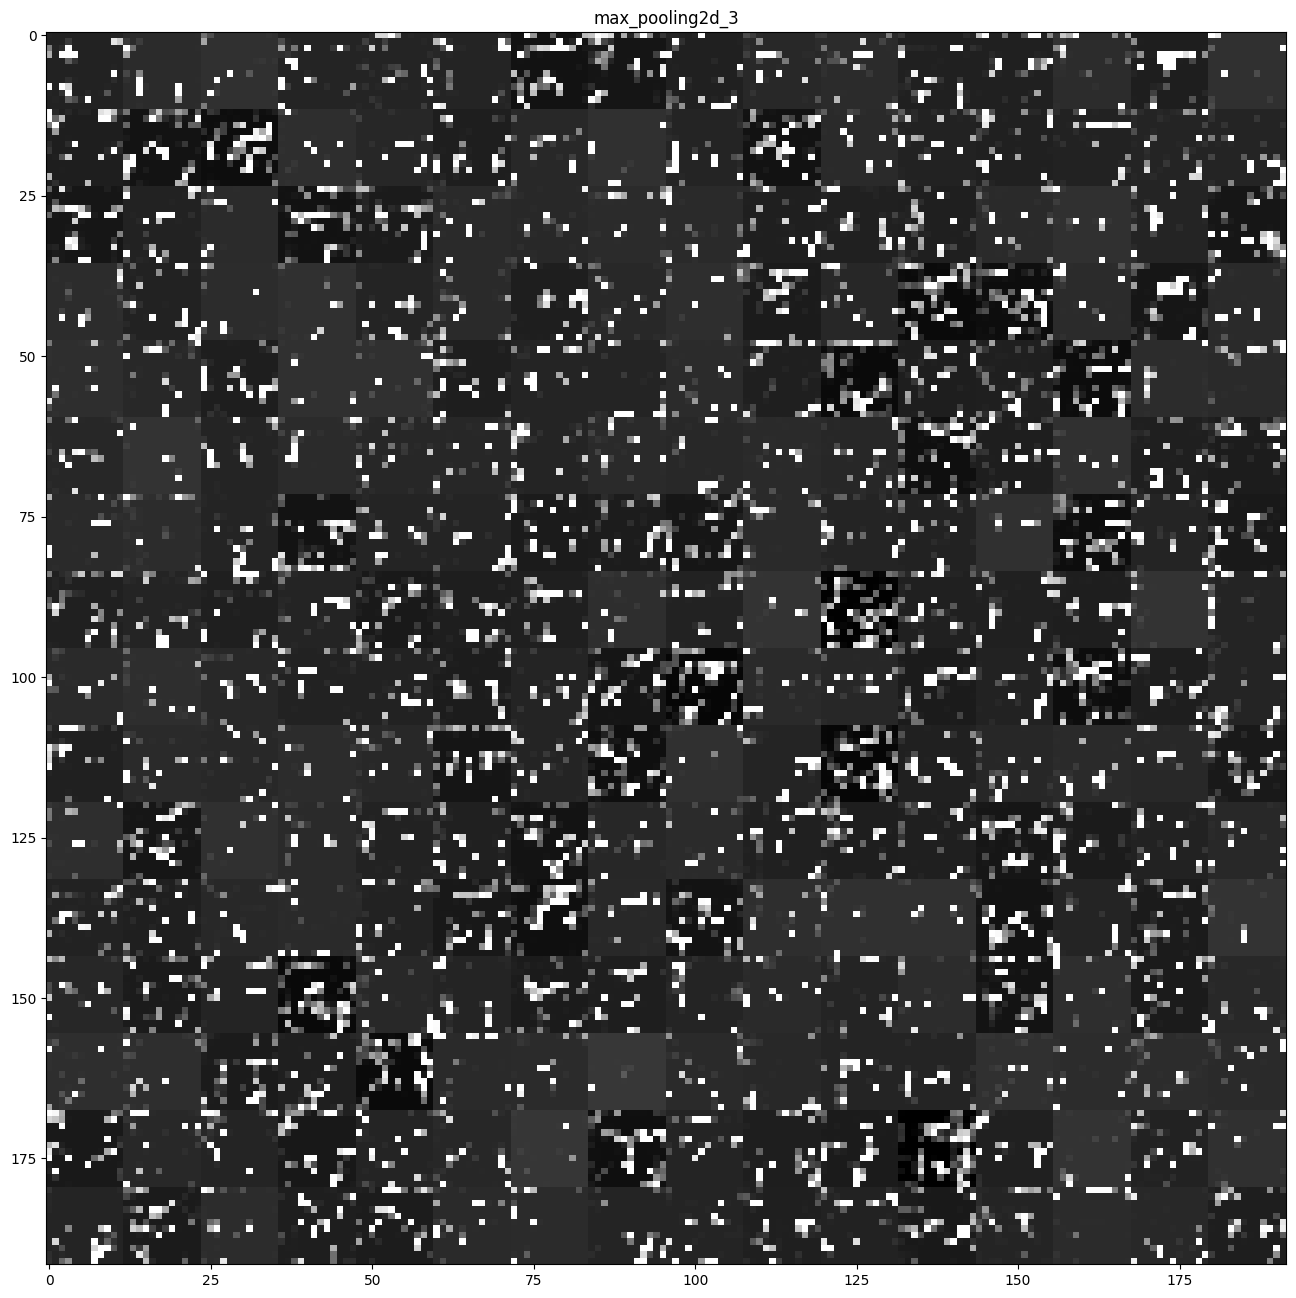

In [ ]:
def display_activations(activation_model, input_image):
    activations = activation_model.predict(input_image)
    layer_names = [layer.name for layer in activation_model.layers]

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        images_per_row = 16
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
        plt.show()

# Assume `input_image` is preprocessed and ready for prediction
display_activations(activation_model, np.expand_dims(ds.test['X'][0], axis=0))

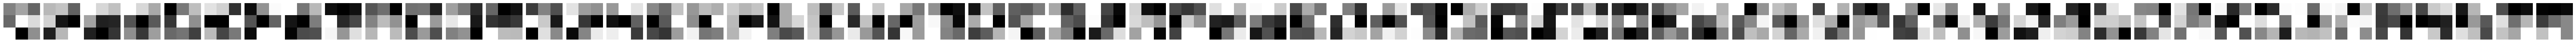

In [ ]:
def display_filters(layer):
    weights = layer.get_weights()  # This returns a list of numpy arrays
    if len(weights) == 0:
        print("No weights in this layer")
        return

    filters = weights[0]  # Weights are always the first item
    if len(weights) > 1:
        biases = weights[1]  # Biases are the second item, if they exist

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[-1]
    n_channels = filters.shape[-2]

    fig, axs = plt.subplots(1, n_filters, figsize=(n_filters*1.5, 3))
    fig.subplots_adjust(hspace = 0.5, wspace=0.1)
    axs = axs.flatten()

    for i in range(n_filters):
        f = filters[:, :, :, i]
        for j in range(n_channels):
            ax = axs[i * n_channels + j]
            ax.imshow(f[:, :, j], cmap='gray')
            ax.axis('off')

    plt.show()

# Example usage
# Ensure you select an appropriate convolutional layer
if 'conv' in v_model.model.layers[1].name:
    display_filters(v_model.model.layers[1])
else:
    print("Selected layer is not a convolutional layer")

## Comparison with pre-trained ViT

In [ ]:
from transformers import pipeline
from PIL import Image
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = pipeline("image-classification", model="motheecreator/vit-Facial-Expression-Recognition", device=0)
device

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

device(type='cuda')

In [ ]:
test_X, test_y = ds.test['X'], ds.test['y']

In [ ]:
pillow_X = [Image.fromarray((x * 255).astype('uint8')) for x in test_X]

In [ ]:
batches_X = []

for i in range(0, len(pillow_X), 4):
    batch = []
    for j in range(min(4, len(pillow_X) - i)):
        batch.append(pillow_X[i + j])
    batches_X.append(batch)


In [ ]:
prediction_y = []

for batch in tqdm(batches_X):
    predictions = pipe(batch)
    prediction_y.extend(predictions)

  0%|          | 0/898 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
labels_to_classes = {
    'anger': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

In [ ]:
def find_max_labels(prediction_groups):
    max_labels = []
    for predictions in prediction_groups:
        scores = [item['score'] for item in predictions]
        max_index = scores.index(max(scores))
        max_labels.append(labels_to_classes[predictions[max_index]['label']])
    return np.array(max_labels)

[0 5 6 ... 0 3 2]
Size of test data: 3589
Wrong predictions: 300


              precision    recall  f1-score   support

           0       0.91      0.87      0.89       491
           1       0.89      0.93      0.91        55
           2       0.85      0.88      0.86       528
           3       0.98      0.96      0.97       879
           4       0.89      0.89      0.89       594
           5       0.95      0.91      0.93       416
           6       0.90      0.95      0.92       626

    accuracy                           0.92      3589
   macro avg       0.91      0.91      0.91      3589
weighted avg       0.92      0.92      0.92      3589



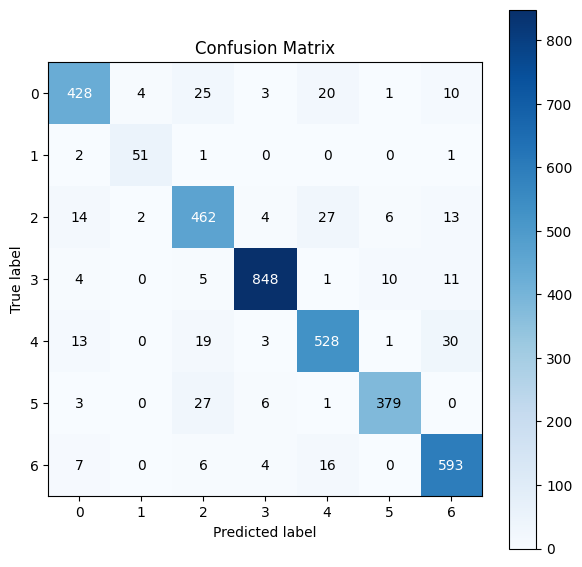

In [ ]:
y_predicted = find_max_labels(prediction_y)
print(y_predicted)
scikitplot.metrics.plot_confusion_matrix(np.argmax(ds.test['y'], axis=1), y_predicted, figsize=(7,7))

print(f"Size of test data: {len(ds.test['y'])}")
print(f"Wrong predictions: {np.sum(np.argmax(ds.test['y'], axis=1) != y_predicted)}\n\n")
print(classification_report(np.argmax(ds.test['y'], axis=1), y_predicted))

# Video

In [ ]:
classes_to_label = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6:'neutral'
}

In [ ]:
def preprocess_frame(frame):
    # Resize and scale the frame
    frame_resized = cv2.resize(frame, (48, 48))  # Resize to match the input size expected by the model
    frame_normalized = frame_resized / 255  # Scale pixel values to [0, 1]
    frame_gray = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)
    return cv2.rotate(frame_gray / 255, cv2.ROTATE_90_CLOCKWISE)

1/1 [==============================] - 0s 27ms/step


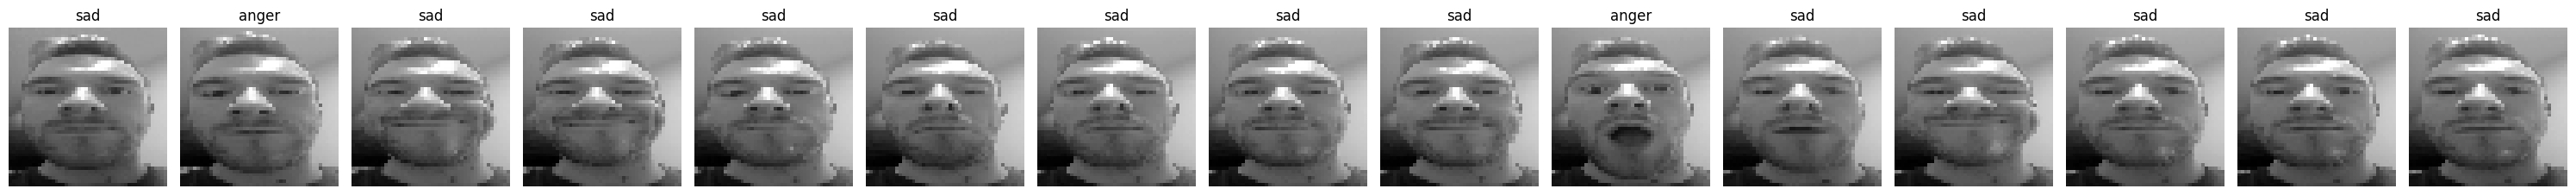

In [ ]:
def plot_predictions(video_path, model, skip_frames=0, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    displayed_frames = 0
    fig, axs = plt.subplots(1, max_frames, figsize=(30, 20))  # Set up the subplots

    try:
        while displayed_frames < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % (skip_frames + 1) == 0:
                processed_frame = preprocess_frame(frame)
                prediction = model.predict(np.expand_dims(processed_frame, axis=0))

                axs[displayed_frames].imshow(processed_frame, cmap='gray')  # Display in a subplot
                print(classes_to_label[np.argmax(prediction)])
                axs[displayed_frames].set_title(classes_to_label[np.argmax(prediction)])
                axs[displayed_frames].axis('off')  # Hide axes for clarity

                displayed_frames += 1

            frame_count += 1

    except Exception as e:
        print(e)

    finally:
        cap.release()
        plt.tight_layout()  # Adjust subplots to fit into the figure area.
        plt.show()

# Example usage
model = tf.keras.models.load_model('final.pb')
plot_predictions('video.mp4', model, skip_frames=20, max_frames=15)

1/1 [==============================] - 0s 29ms/step


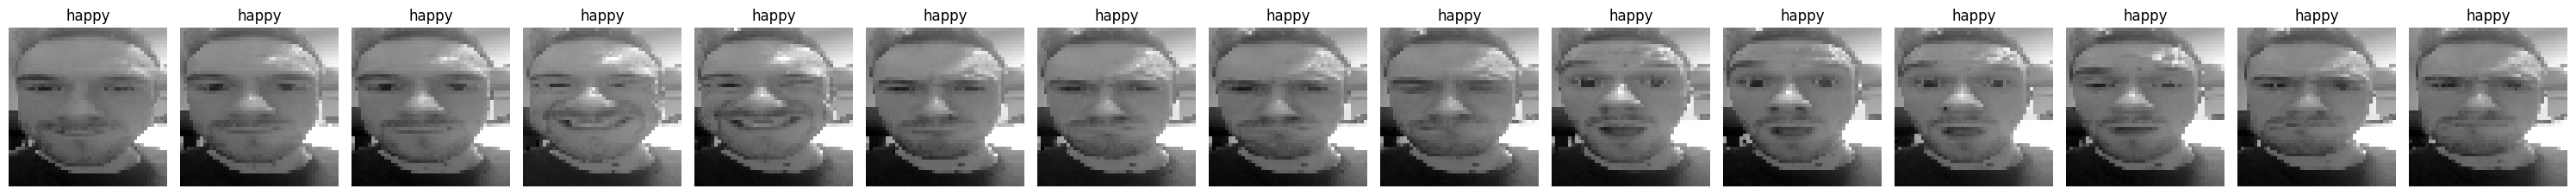

In [ ]:
plot_predictions('video1.mp4', model, skip_frames=20, max_frames=15)